In [4]:
%run data.py

### Read data from NYC Open Data.

In [5]:
results_df = fetch_nycOpenData(nyc_publicHealthNoti, 100, 20000)
results_df.head(10)

,record_id,date_and_time,notificationtype,notification_title,email_body
0,17077,2020-05-10T13:27:00.000,Road Closure,Traffic Delays- BQE at Cadman Plaza (BK),Notification issued 05-10-2020 at 1:27 PM. ...
1,17076,2020-05-10T09:43:00.000,Public Awareness,Police Activity (BK),Notification issued 05-10-2020 at 9:43 AM. ...
2,17075,2020-05-09T23:10:00.000,Mass Transit Restoration,MTA Restoration - 2 Train (BK),Notification issued 5-9-2020 at 11:10 PM. F...
3,17074,2020-05-09T22:58:00.000,Mass Transit Disruption,MTA Suspension - 2 Train (BK),Notification issued 5-9-2020 at 10:58 PM. ...
4,17073,2020-05-09T17:44:00.000,Road Closure,Traffic Delays- Van Wyck Expressway at Belt Pa...,Notification issued 05-09-2020 at 5:44 PM. ...
5,17072,2020-05-09T15:34:00.000,Utility,Power Outage - Whitestone (QN),Notification issued 05-09-2020 at 3:34 PM. Con...
6,17071,2020-05-09T08:15:00.000,Weather,Intermittent Wind Gusts - 5/9 (CW),Notification issued 05-09-2020 at 8:15 AM. ...
7,17070,2020-05-09T08:00:00.000,Environmental,Waterbody Advisory 5/9,The following Waterbody Advisories are reporte...
8,17069,2020-05-09T01:37:00.000,Weather,Special Weather Statement - 5/9 (CW),NaN
9,17068,2020-05-08T21:34:00.000,Road Closure,Traffic Delays - CBE at Jerome Ave (BX),Notification issued 05-08-2020 at 9:34 PM. ...


In [35]:
df = pandas_to_spark(results_df)

In [36]:
from pyspark.sql.functions import to_timestamp
from pyspark.sql.functions import month, year

#select notification type with "public health"
df = df.filter(df["notificationtype"] == "Public Health")

# group table by month.
#filter date and time from 06/2019
df = df.withColumn("date", to_timestamp("date_and_time", "yyyy-MM-dd'T'HH:mm:ss.SSS"))
df = df.filter(df["date"] >= to_timestamp(f.lit('2019-06-01 00:00:00')).cast('timestamp'))
df = df.groupBy(month("date").alias("month")).count()
df = df.filter(df["month"] != 5)

df = df.withColumn("month_name", 
                                            f.when(f.col('month') == 1, "2020-01")\
                                            .when(f.col('month') == 2, "2020-02")\
                                            .when(f.col('month') == 3, "2020-03")\
                                            .when(f.col('month') == 4, "2020-04")\
                                            .when(f.col('month') == 6, "2019-06")\
                                            .when(f.col('month') == 7, "2019-07")\
                                            .when(f.col('month') == 8, "2019-08")\
                                            .when(f.col('month') == 9, "2019-09")\
                                            .when(f.col('month') == 10, "2019-10")\
                                            .when(f.col('month') == 11, "2019-11")\
                                            .when(f.col('month') == 12, "2019-12"))

df = df.orderBy("month_name")
df = df.select(df["month_name"], df["count"].alias("publicHealthNoti"))
df.show()

+----------+----------------+
|month_name|publicHealthNoti|
+----------+----------------+
|   2019-06|               2|
|   2019-07|               7|
|   2019-08|               7|
|   2019-09|               5|
|   2019-12|              19|
|   2020-03|              48|
|   2020-04|              65|
+----------+----------------+



In [37]:
newRow = spark.createDataFrame([("2019-10", 0), ("2019-11", 0), ("2020-01", 0), ("2020-02", 0)])
df = df.union(newRow)
df = df.orderBy("month_name")
df.show()

+----------+----------------+
|month_name|publicHealthNoti|
+----------+----------------+
|   2019-06|               2|
|   2019-07|               7|
|   2019-08|               7|
|   2019-09|               5|
|   2019-10|               0|
|   2019-11|               0|
|   2019-12|              19|
|   2020-01|               0|
|   2020-02|               0|
|   2020-03|              48|
|   2020-04|              65|
+----------+----------------+



### Calculate the average license applications before March 2020. 

In [38]:
avg_data = df.filter(df["month_name"] != "2020-03")
avg_data = avg_data.filter(df["month_name"] != "2020-04")
avg_data.show()

+----------+----------------+
|month_name|publicHealthNoti|
+----------+----------------+
|   2019-06|               2|
|   2019-07|               7|
|   2019-08|               7|
|   2019-09|               5|
|   2019-10|               0|
|   2019-11|               0|
|   2019-12|              19|
|   2020-01|               0|
|   2020-02|               0|
+----------+----------------+



In [40]:
avg_data.createOrReplaceTempView("avg_data")
avg_num = spark.sql("SELECT avg(publicHealthNoti) as avg_num FROM avg_data")
avg_num = avg_num.rdd.map(list)
avg_number = avg_num.take(1)[0][0]
print("Average public health notifications before March 2020 is: ", avg_number)

Average public health notifications before March 2020 is:  4.444444444444445


### Calculate the rising rate.

In [42]:
df.createOrReplaceTempView("latest_data")
latest_number = spark.sql("SELECT publicHealthNoti FROM latest_data WHERE month_name = \
                                     (SELECT max(month_name) FROM  latest_data)")

latest_number = latest_number.rdd.map(list)
latest_number = latest_number.take(1)[0][0]
rising_rate = (latest_number - avg_number) / avg_number
print("Rising rate is: ", rising_rate)

rising_rate = rising_rate * 100

Rising rate is:  13.625


In [43]:
rising_rate_str = "↑" + str('%.2f' % rising_rate) + "%"

In [46]:
import matplotlib.pyplot as plt
plt.close('all')

data = df.toPandas()
data.head(11)

,month_name,publicHealthNoti
0,2019-06,2
1,2019-07,7
2,2019-08,7
3,2019-09,5
4,2019-10,0
5,2019-11,0
6,2019-12,19
7,2020-01,0
8,2020-02,0
9,2020-03,48


### Plot.

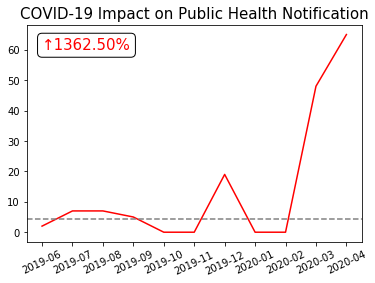

In [47]:
#public health notification
plt.plot("month_name", "publicHealthNoti", data = data, color = "red")

#average job applications before March 2020
plt.axhline(y = avg_number,ls = "dashed",color = "grey") 

#title
plt.title("COVID-19 Impact on Public Health Notification",fontsize = 15)

#annotaion: rising rate
bbox_props = dict(boxstyle="round", facecolor = "white")
plt.text(0, 60, rising_rate_str, size = 15, color = "red", bbox=bbox_props)

plt.xticks(rotation=25)
plt.show()